In [1]:
!pip install pyltr

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


In [2]:
!pip install more_itertools

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


In [3]:
import warnings
import pyltr
import copy 
warnings.filterwarnings('ignore')

//miniconda3/envs/olp-sdk-for-python-0.6.0-env/lib/python3.7/site-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


In [4]:
from sklearn.cluster import KMeans
import numpy as np
from more_itertools import sort_together

In [22]:
## Finding the key inside a dict
def find_matching_key_index(id, data):
    for i in range(0,len(data)):
        if data[i]['id'] == id:
            return i
    return -1


## partition data cluster wise
def partition_data_cluster_wise(X_d,Y_d,T_q,labels):
    data_dict = []
    for i in range(0, len(labels)):
        idx = find_matching_key_index(labels[i],data_dict )
        if idx == -1:
            data = {}
            data['id'] = labels[i]
            data['data'] = X_d[i:i+1]
            data['label'] = Y_d[i:i+1]
            data['tqid'] = T_q[i:i+1]
            data_dict.append(data)
        else :
            data = {}
            d =  data_dict[idx]['data']
            la =  data_dict[idx]['label']
            tq =  data_dict[idx]['tqid']
            data_dict[idx]['data'] = np.concatenate((d, X_d[i:i+1]), axis=0)
            data_dict[idx]['label'] = np.concatenate((la, Y_d[i:i+1]), axis=0)
            data_dict[idx]['tqid'] = np.concatenate((tq, T_q[i:i+1]), axis=0)

    return data_dict

## concatenate all the evaluation across clusters
def concatenate_cluster_eval(p_data):
    m_data = {}
    m_data['data'] = np.array([[np.array(xx)] for xx in  p_data[0]['eval']])
    m_data['label'] = p_data[0]['label']
    m_data['tqid'] = p_data[0]['tqid']
    for j in range(1, len(p_data)):
        dd = np.array([[np.array(xx)] for xx in  p_data[j]['eval']])
        m_data['data'] = np.concatenate((m_data['data'] ,dd), axis=0)
        m_data['label'] = np.concatenate((m_data['label'] , p_data[j]['label']), axis=0)
        m_data['tqid'] = np.concatenate((m_data['tqid'] , p_data[j]['tqid']), axis=0)
    return m_data

## train model using LamdaMart 
def train_model_using_LambdaMART(p_data):
    for j in range(0,len(p_data)):
        metric = pyltr.metrics.NDCG(k=5)
    
        model = pyltr.models.LambdaMART(
            metric=metric,
            n_estimators=500,
            verbose=0,
        )

        model.fit(p_data[j]['data'], p_data[j]['label'], p_data[j]['tqid'])
        p_data[j]['model'] = model
        p_data[j]['metric'] = metric
      
    return p_data

##evaluate partiotioned data
def evaluate_partitioned_data(p_data) :
    for j in range(0,len(p_data)):
        Epred = p_data[j]['model'].predict(p_data[j]['data'])
        evl_arr = evalute_preds_1(p_data[j]['label'],Epred,p_data[j]['tqid'], p_data[j]['metric'])
        p_data[j]['eval'] = evl_arr
    return p_data

##evaluate on all features
def evaluate_features(p_data, X, Y, tqids):
    eval_dict_arr = []
    eval_dict = {}
    for j in range(0,len(p_data)):
        Epred = p_data[j]['model'].predict(X)
        evl_arr = evalute_preds_1(Y, Epred, tqids, p_data[j]['metric'])
        eval_dict['id'] = j
        eval_dict['features'] = X
        eval_dict['eval'] = evl_arr
        eval_dict_arr.append(eval_dict)
    return eval_dict_arr
  
    
def mean_val_pred(Y,y_pred,Qids, met):
    evl_arr = evalute_preds_1(Y, y_pred, Qids, met)
    return np.mean(evl_arr)
    
"""
Evaluate prediction
"""
def evalute_preds_1(Y,Y_pred,Qids, met):
    ev_arr = []
    query_groups = pyltr.util.group.get_groups(Qids)
    for qd, a,b in query_groups:
        m = met.evaluate_preds(qd,Y[a:b], Y_pred[a:b] )
        if m > 1.0:
            m = 0
        #copy the same value b-a times
        ev_arr.extend([m]*(b-a))
    return  ev_arr

"""
Group data inside a cluster based on ids as ids needs to be  contiguous.
It may happen that after clustering the tids are not contigous then LambdaMart will throw error
"""
def group_tqids(p_data):
    for j in range(0, len(p_data)):
        aa = p_data[j]['data']
        bb = p_data[j]['label']
        cc = p_data[j]['tqid']
        ord_data = sort_together([cc,aa.flatten(),bb])
        p_data[j]['data'] = np.array([[np.array(d)] for d in ord_data[1]])
        p_data[j]['label'] = np.array(ord_data[2])
        p_data[j]['tqid'] = np.array(ord_data[0])
    return p_data

def mean_values(p_data, tx, ty, tqids ):
    elm_rem = -1
    mean_vals  = []
    for k in range(0,len(p_data)):
       
        Epred = p_data[k]['model'].predict(tx)
        m_val = mean_val_pred(ty, Epred,tqids, p_data[k]['metric'])
        #m_val =  p_data[k]['metric'].calc_mean(tqids, ty, Epred)

        mean_vals.append(m_val)
    return p_data, mean_vals     

In [6]:
with open('./MQ2007/Fold1/train.txt') as trainfile, \
         open('./MQ2007/Fold1/vali.txt') as valifile, \
         open('./MQ2007/Fold1/test.txt') as evalfile:
    TX, Ty, Tqids, _ = pyltr.data.letor.read_dataset(trainfile)
    VX, Vy, Vqids, _ = pyltr.data.letor.read_dataset(valifile)
    EX, Ey, Eqids, _ = pyltr.data.letor.read_dataset(evalfile)

### Train Base Line model on all features

In [7]:
base_metric = pyltr.metrics.NDCG(k=5)
    
base_model = pyltr.models.LambdaMART(
            metric=base_metric,
            n_estimators=500,
            verbose=0,
)

base_model.fit(TX,Ty, Tqids)

#### Step 1, take the average of the features

In [8]:
##Step 1
## compute the average of the feature
NO_OF_CLUSTER=5
f_avg = np.array([[np.mean(subarray)] for subarray in TX])
##cluster the feature into n clusters as stated in the research paper
km_f_avg = KMeans(n_clusters= NO_OF_CLUSTER, random_state=0).fit(f_avg)
km_f_avg.labels_

array([3, 2, 0, ..., 4, 3, 1], dtype=int32)

#### Train the model on each cluster

In [9]:
## Arrange the data cluster wise
partitioned_data = partition_data_cluster_wise(f_avg,Ty,Tqids,km_f_avg.labels_)
##train model for each cluster
partitioned_data = train_model_using_LambdaMART(partitioned_data)

#### Evaluate partitioned data and create new features set based in the evaluation

In [10]:
##evaluate partiotioned data
partitioned_data = evaluate_partitioned_data(partitioned_data)
_data_1 = copy.deepcopy(partitioned_data)

##merge partitioned data as mentioned in the paper [q11,q12, ..q1n, q21,q22, ...., q41,...]
merg_data = concatenate_cluster_eval(partitioned_data)


### Step 2 cluster data on new feature set created from evaluation and train it again

In [11]:
km_f_avg = KMeans(n_clusters=NO_OF_CLUSTER, random_state=0).fit(merg_data['data'])
km_f_avg.labels_

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [12]:
partitioned_data = partition_data_cluster_wise(merg_data['data'],merg_data['label'],merg_data['tqid'],km_f_avg.labels_)
##group the ids as it needs to be contogous
partitioned_data = group_tqids(partitioned_data)
##train model again on this dataset
partitioned_data = train_model_using_LambdaMART(partitioned_data)

#### Evaluate partitioned data and create new feature set based in second clusters

In [13]:
##evaluate partiotioned data
partitioned_data = evaluate_partitioned_data(partitioned_data)
_data_2 = copy.deepcopy(partitioned_data)
##merge partitioned data as mentioned in the paper [q11,q12, ..q1n, q21,q22, ...., q41,...]
merg_data = concatenate_cluster_eval(partitioned_data)

#### Step 3 cluster data for the last time  on new feature set created from evaluation and train it again

In [14]:
km_f_avg = KMeans(n_clusters=NO_OF_CLUSTER, random_state=0).fit(merg_data['data'])
partitioned_data = partition_data_cluster_wise(merg_data['data'],merg_data['label'],merg_data['tqid'],km_f_avg.labels_)
##group the ids as it needs to be contogous
partitioned_data= group_tqids(partitioned_data)
##train model again on this dataset
partitioned_data = train_model_using_LambdaMART(partitioned_data)
##evaluate partiotioned data
partitioned_data = evaluate_partitioned_data(partitioned_data)
_data_3 = copy.deepcopy(partitioned_data)

### Plot mean value across cluster

In [15]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

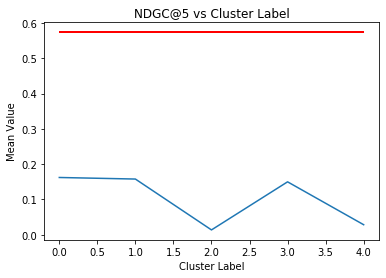

In [26]:
p_data, m_vals = mean_values(partitioned_data, TX, Ty,Tqids)

#compute base value
Epred = base_model.predict(TX)
base_val = base_metric.calc_mean(Tqids, Ty, Epred)
plt.plot(m_vals)
plt.title('NDGC@5 vs Cluster Label')
plt.xlabel("Cluster Label")
plt.ylabel("Mean Value")
plt.hlines(y=base_val, xmin=0, xmax=4, linewidth=2, color='r')
plt.show()

### Prepare training data for cluster classification
   - Take top 10 query and the corresponding model as the label
   - Take average of the 10 queries 

In [ ]:
f_list = []
lab_list = []
for l in range(0, len(partitioned_data)):
    ##take top 10 document
    Epred = partitioned_data[l]['model'].predict(TX)
    x = evalute_preds_1(Ty,Epred,Tqids, partitioned_data[l]['metric'])
    r, f = sort_together([x,TX], reverse = True)
    f_list.append(np.mean(np.array(f[:10]), axis=0))
    #lab_list.extend([partitioned_data[l]['id']])
    lab_list.extend([l])
X_data = np.array(f_list)
y_data = np.array(lab_list)

### Train a Logistic Regression on this data set for predicting the cluster

In [ ]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(X_data, y_data)

### Choose model using classifier and the predict using selected model

In [ ]:
sel_model_val = []
base_model_val = []
for p in range(0, len(TX)-1):
    cluster_idx = clf.predict(TX[p:p+1, :])[0]  
    Epred = partitioned_data[cluster_idx]['model'].predict(TX[p:p+1, :])
    #m_val = partitioned_data[cluster_idx]['metric'].calc_mean(Tqids[p:p+1], Ty[p:p+1], Epred)
    m_val = mean_val_pred(Ty[p:p+1],Epred,  Tqids[p:p+1], partitioned_data[cluster_idx]['metric'])##.calc_mean(Tqids[p:p+1], Ty[p:p+1], Epred) mean_val_pred
    sel_model_val.append(m_val)
    Epred_b = base_model.predict(TX[p:p+1, :])
    m_val_base = base_metric.calc_mean(Tqids[p:p+1], Ty[p:p+1], Epred_b)
    base_model_val.append(m_val_base)

### Plot document wise NDGC

In [ ]:
plt.plot(sel_model_val)
plt.title('NDGC@5 vs Cluster Label')
plt.xlabel("Cluster Label")
plt.ylabel("Mean Value")
plt.show()